# Preprocessing

This notebook prepares the *Pastel de Nata* data for modeling.
Based on the findings from the exploratory analysis, we handle missing values, standardize the representation of categorical fields, deal with outliers, split the data into train/validation sets, and apply appropriate scaling and transformations.


In [1]:
from networkx.algorithms.shortest_paths.unweighted import predecessor
from sklearn.impute import KNNImputer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy.stats import boxcox

In [2]:
pastel_d_nata_lrn = pd.read_csv('Nata_Files/learn.csv', index_col=0)
pastel_d_nata_pred = pd.read_csv('Nata_Files/predict.csv', index_col=0)

### Preparation

The exploratory analysis revealed that several features are skewed and contain substantial outliers.
To address this, we first clean and harmonize the raw learning and prediction datasets, then systematically inspect features to remove problematic records, cap extreme values where justified, and prepare the data for downstream modeling.


In [3]:
pastel_d_nata_lrn = pastel_d_nata_lrn[pastel_d_nata_lrn['quality_class'].isna()==False]

We restrict the learning dataset to observations with a known `quality_class`, since this label is required to train supervised models.
Rows where `quality_class` is missing are excluded from the training set but can still be used later for prediction if needed.


### Harmonizing origin information

The `origin` column appears in text form with multiple variants for Lisbon and Porto (for example, “Lisboa”, “Lisbon”).
To make this feature usable in modeling, we normalize these entries to a binary numeric encoding: `1` for Lisbon and `0` for Porto, ensuring a consistent representation across both learning and prediction datasets.


In [4]:
def origin_replace(df):
    origin_update = []
    for city in df['origin']:
        if 'lisboa' in str(city).lower() or 'lisbon' in str(city).lower():
            city= 1
            origin_update.append(city)
        elif 'porto' in str(city).lower():
            city= 0
            origin_update.append(city)
        else:
            origin_update.append(city)
    df.loc[:,'origin'] = pd.Series(origin_update, index=df.index)
    return df

In [5]:
pastel_d_nata_lrn = origin_replace(pastel_d_nata_lrn)

The prediction dataset is cleaned to be uniform with the learning dataset

In [6]:
pastel_d_nata_pred = origin_replace(pastel_d_nata_pred)

In [7]:
prepped_pred = pastel_d_nata_pred.drop(['notes_baker', 'pastry_type'], axis=1)

Free‑text notes and high‑cardinality categorical fields with many missing values such as `notes_baker` and `pastry_type` are removed from the prediction dataset at this stage.
These variables are not straightforward to encode for tabular models within the project scope, and excluding them keeps the feature space aligned between learning and prediction data.


### Train–validation split

To evaluate models in a controlled way, we split the cleaned learning dataset into training and validation subsets.
The features matrix `X` contains all predictors except `quality_class`, while the target vector `y` stores the corresponding labels; a 75/25 split with a fixed random seed ensures reproducible results.


In [8]:
X=pastel_d_nata_lrn.drop('quality_class',axis=1)
y=pastel_d_nata_lrn[['quality_class']]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state = 15)

### Handling outliers

EDA highlighted extreme values in `final_temperature`, `salt_ratio`, `vanilla_extract`, and `baking_duration`.
Here we revisit these variables, inspect the most extreme observations, and cap them using domain‑motivated limits (rather than simply trimming the top *n* values) to reduce the influence of unrealistic measurements while preserving as much data as possible.


In [10]:
pastel_d_nata_lrn.sort_values('final_temperature', ascending=False)[['final_temperature','quality_class']].head(10)
#capping at 490

,final_temperature,quality_class
id,,
1272,722.0,KO
5039,611.0,KO
5025,512.0,KO
2828,498.0,KO
3142,486.0,KO
2640,484.0,OK
3347,477.0,KO
2107,468.0,OK
930,458.0,KO


We cap `final_temperature` at 490°C, as higher readings are likely due to measurement errors or atypical process conditions that are not representative of normal production.


In [11]:
pastel_d_nata_lrn.sort_values('salt_ratio', ascending=False)[['salt_ratio','quality_class']].head(15)
#capping at 420

,salt_ratio,quality_class
id,,
2695,640.32,KO
651,636.67,KO
2525,472.03,KO
3223,431.76,KO
2897,419.47,OK
4221,414.71,KO
3344,410.58,OK
2894,407.05,KO
43,402.47,KO


We cap `salt_ratio` at 420g/kg, as larger ratios all lead to the same result.


In [12]:
pastel_d_nata_lrn.sort_values('sugar_content', ascending=False)[['sugar_content','quality_class']].head(5)

,sugar_content,quality_class
id,,
58,656.5,OK
1782,332.5,OK
3736,270.9,OK
558,262.1,OK
595,229.7,KO


In [13]:
pastel_d_nata_lrn.sort_values('baking_duration', ascending=False)[['baking_duration','quality_class']].head(12)
#capping at 63

,baking_duration,quality_class
id,,
2227,89.0,KO
975,79.0,KO
1843,77.0,KO
331,73.0,KO
4776,71.0,KO
4752,69.0,KO
4728,67.0,KO
2607,65.0,KO
1614,63.0,KO


We cap `baking_duratiion` at 63 min, as longer baking durations are likely are not representative of normal production.


In [14]:
#cutting the extreme values in order to mitigate outliers
X_train_cap= X_train[(X_train.final_temperature<490)|(X_train.final_temperature.isna())]
X_train_cap= X_train[(X_train.salt_ratio<420)|(X_train.salt_ratio.isna())]
X_train_cap= X_train[(X_train.baking_duration<63)|(X_train.baking_duration.isna())]
X_train= X_train[X_train.sugar_content>=400]

In [15]:
X_train_cap.drop(['notes_baker','pastry_type'], axis=1).isna().sum().sort_values(ascending=False)

origin               117
lemon_zest_ph         20
cream_fat_content     18
final_temperature     18
oven_temperature      18
egg_temperature       17
egg_yolk_count        17
ambient_humidity      15
sugar_content         15
preheating_time       13
vanilla_extract       10
salt_ratio             9
baking_duration        0
cooling_period         0
dtype: int64

### Scaling

To make the features comparable and stabilize the effect of outliers, we applied feature scaling based on the distribution of each variable.
Approximately Gaussian variables were standardized to zero mean and unit variance, while more skewed features were transformed with more robust or non‑linear scalers, ensuring that no single feature dominates the learning process due to its scale.


In [29]:
#splitting the data in different types of scaling:
def individual_scaling(X_train, X_val, pred):
    z_scaler = StandardScaler()
    r_scaler = RobustScaler()
    p_scaler = PowerTransformer()
    m_scaler = MinMaxScaler()

    X_train_scaled = pd.DataFrame(index=X_train.index)
    X_val_scaled = pd.DataFrame(index=X_val.index)
    scaled_pred = pd.DataFrame(index=pred.index)
    #scaling ambient_humidity
    if 'ambient_humidity' in X_train.columns:
        X_train_scaled['ambient_humidity'] = m_scaler.fit_transform(X_train[['ambient_humidity']])
        X_val_scaled['ambient_humidity'] = m_scaler.transform(X_val[['ambient_humidity']])
        scaled_pred['ambient_humidity'] = m_scaler.transform(pred[['ambient_humidity']])
    #scaling baking_duration
    if 'baking_duration' in X_train.columns:
        X_train_scaled['baking_duration'] = p_scaler.fit_transform(X_train[['baking_duration']])
        X_val_scaled['baking_duration'] = p_scaler.transform(X_val[['baking_duration']])
        scaled_pred['baking_duration'] = p_scaler.transform(pred[['baking_duration']])
    #scaling cooling_period
    if 'cooling_period' in X_train.columns:
        X_train_scaled['cooling_period'] = r_scaler.fit_transform(X_train[['cooling_period']])
        X_val_scaled['cooling_period'] = r_scaler.transform(X_val[['cooling_period']])
        scaled_pred['cooling_period'] = r_scaler.transform(pred[['cooling_period']])
    #scaling cream_fat_content
    if 'cream_fat_content' in X_train.columns:
        X_train_scaled['cream_fat_content'] = z_scaler.fit_transform(X_train[['cream_fat_content']])
        X_val_scaled['cream_fat_content'] = z_scaler.transform(X_val[['cream_fat_content']])
        scaled_pred['cream_fat_content'] = z_scaler.transform(pred[['cream_fat_content']])
    #scaling egg_temperature
    if 'egg_temperature' in X_train.columns:
        egg_transform = pd.DataFrame(boxcox(X_train.egg_temperature, lmbda=-0.2))
        egg_transform_val = pd.DataFrame(boxcox(X_val.egg_temperature, lmbda=-0.2))
        egg_transform_pred = pd.DataFrame(boxcox(pred.egg_temperature, lmbda=-0.2))
        X_train_scaled['egg_temp'] = r_scaler.fit_transform(egg_transform)
        X_val_scaled['egg_temp'] = r_scaler.transform(egg_transform_val)
        scaled_pred['egg_temp'] = r_scaler.transform(egg_transform_pred)
    #scaling egg_yolk_content
    if 'egg_yolk_count' in X_train.columns:
        X_train_scaled['egg_yolk_cnt'] = m_scaler.fit_transform(X_train[['egg_yolk_count']])
        X_val_scaled['egg_yolk_cnt'] = m_scaler.transform(X_val[['egg_yolk_count']])
        scaled_pred['egg_yolk_cnt'] = m_scaler.transform(pred[['egg_yolk_count']])
    #scaling final_temperature
    if 'final_temperature' in X_train.columns:
        X_train_scaled['final_temp'] = r_scaler.fit_transform(X_train[['final_temperature']])
        X_val_scaled['final_temp'] = r_scaler.transform(X_val[['final_temperature']])
        scaled_pred['final_temp'] = r_scaler.transform(pred[['final_temperature']])
    #scaling lemon_zest_ph
    if 'lemon_zest_ph' in X_train.columns:
        X_train_scaled['lemon_zest_ph'] = z_scaler.fit_transform(X_train[['lemon_zest_ph']])
        X_val_scaled['lemon_zest_ph'] = z_scaler.transform(X_val[['lemon_zest_ph']])
        scaled_pred['lemon_zest_ph'] = z_scaler.transform(pred[['lemon_zest_ph']])
    #scaling oven_temperature
    if 'oven_temperature' in X_train.columns:
        X_train_scaled['oven_temp'] = r_scaler.fit_transform(X_train[['oven_temperature']])
        X_val_scaled['oven_temp'] = r_scaler.transform(X_val[['oven_temperature']])
        scaled_pred['oven_temp'] = r_scaler.transform(pred[['oven_temperature']])
    #scaling preheating_time
    if 'preheating_time' in X_train.columns:
        preheat_transform = pd.DataFrame(boxcox(X_train.preheating_time, lmbda=-0.2))
        preheat_transform_val = pd.DataFrame(boxcox(X_val.preheating_time, lmbda=-0.2))
        preheat_transform_pred = pd.DataFrame(boxcox(pred.preheating_time, lmbda=-0.2))
        X_train_scaled['preheat_time'] = z_scaler.fit_transform(preheat_transform)
        X_val_scaled['preheat_time'] = z_scaler.transform(preheat_transform_val)
        scaled_pred['preheat_time'] = z_scaler.transform(preheat_transform_pred)
    #scaling salt_ratio
    if 'salt_ratio' in X_train.columns:
        salt_transform = pd.DataFrame(boxcox(X_train.salt_ratio, lmbda=-0.3))
        salt_transform_val = pd.DataFrame(boxcox(X_val.salt_ratio, lmbda=-0.3))
        salt_transform_pred = pd.DataFrame(boxcox(pred.salt_ratio, lmbda=-0.3))
        X_train_scaled['salt_ratio'] = z_scaler.fit_transform(salt_transform)
        X_val_scaled['salt_ratio'] = z_scaler.transform(salt_transform_val)
        scaled_pred['salt_ratio'] = z_scaler.transform(salt_transform_pred)
    #scaling_sugar_content\
    if 'sugar_content' in X_train.columns:
        X_train_scaled['sugar_content'] = r_scaler.fit_transform(X_train[['sugar_content']])
        X_val_scaled['sugar_content'] = r_scaler.transform(X_val[['sugar_content']])
        scaled_pred['sugar_content'] = r_scaler.transform(pred[['sugar_content']])
    #scaling vanilla_extract
    if 'vanilla_extract' in X_train.columns:
        X_train_scaled['vanilla_extract'] = p_scaler.fit_transform(X_train[['vanilla_extract']])
        X_val_scaled['vanilla_extract'] = p_scaler.transform(X_val[['vanilla_extract']])
        scaled_pred['vanilla_extract'] = p_scaler.transform(pred[['vanilla_extract']])
    #joining binary origin to the new dataframe
    if 'origin' in X_train.columns:
        X_train_scaled = X_train_scaled.join(pd.Series(X_train.origin, name='origin_dummy'))
        X_val_scaled = X_val_scaled.join(pd.Series(X_val.origin, name='origin_dummy'))
        scaled_pred = scaled_pred.join(pd.Series(pred.origin, name='origin_dummy'))
    return X_train_scaled, X_val_scaled, scaled_pred

In [30]:

X_train_scaled, X_val_scaled, scaled_pred = individual_scaling(X_train_cap, X_val, prepped_pred)

In [31]:
X_train_scaled.head()

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temp,egg_yolk_cnt,final_temp,lemon_zest_ph,oven_temp,preheat_time,salt_ratio,sugar_content,vanilla_extract,origin_dummy
id,,,,,,,,,,,,,,
3431,0.500,-0.763618,0.000000,-0.317949,0.424629,0.571429,-0.378151,0.498028,-0.417391,-0.932189,0.166065,-0.263074,-0.388808,1.0
2252,0.200,0.657465,1.071429,-0.468887,-1.130546,0.571429,-1.176471,0.498028,-1.278261,1.877095,0.928549,0.251981,1.557970,0.0
1049,0.625,1.430631,-1.500000,-0.267636,0.194199,0.714286,-1.042017,1.703764,-0.956522,0.395865,0.606290,-0.110935,1.428172,0.0
1639,0.025,-1.543051,-0.071429,0.839240,0.462589,0.285714,0.084034,-0.104840,0.069565,-1.362209,-0.611992,-0.339144,0.025172,1.0
4472,0.775,-1.256788,0.285714,1.090803,0.056564,0.428571,-0.142857,-0.707708,-0.165217,-0.106600,-1.982852,-0.290016,-1.083501,1.0


### Imputation

After scaling, we used a K‑Nearest Neighbors (KNN) imputer to fill in missing values.
For each incomplete sample, the imputer identifies similar observations in the scaled feature space and replaces the missing entries with the average of their neighbors, preserving multivariate relationships rather than imputing with simple global statistics such as the mean or median.


In [32]:
knn_imp = KNNImputer(n_neighbors=10, weights='distance')

In [33]:
X_train_imp = knn_imp.fit_transform(X_train_scaled)
X_val_imp = knn_imp.transform(X_val_scaled)
pred_imp = knn_imp.transform(scaled_pred)
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_scaled.columns, index=X_train_scaled.index)
X_val_imp = pd.DataFrame(X_val_imp, columns=X_val_scaled.columns, index=X_val_scaled.index)
pred_imp = pd.DataFrame(pred_imp, columns=scaled_pred.columns, index=scaled_pred.index)

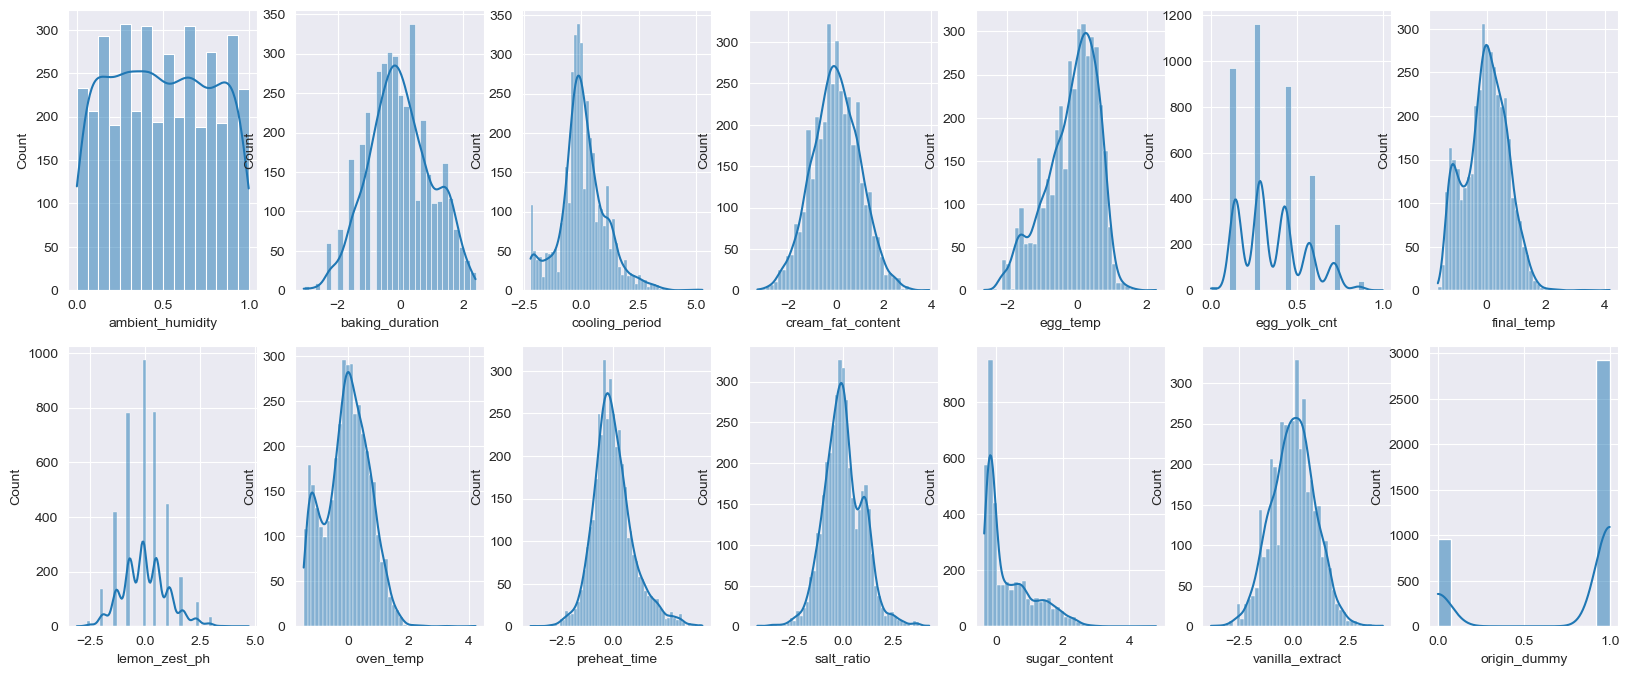

In [34]:
fig, axes = plt.subplots(2, 7, figsize=(20, 8))
axes = axes.flatten()

for nr, col in enumerate(X_train_imp.columns):
    sns.histplot(X_train_imp[col].dropna(), ax=axes[nr], kde=True)

plt.show()

In [35]:
X_train_with_targets = X_train_imp
X_train_with_targets['target']=y_train
X_train_with_targets.to_csv('Nata_Files/processed/train_dataset.csv')

X_val_with_targets = X_val_imp
X_val_with_targets['target'] = y_val
X_val_with_targets.to_csv('Nata_Files/processed/test_dataset.csv')

pred_imp.to_csv('Nata_Files/processed/pred_scaled.csv')